# Forecast Hybrid Production Notebook
Author: George Panagiotou

In [1]:
import pandas as pd
import numpy as np
from comp_utils import *
import os
from sklearn.linear_model import QuantileRegressor
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.metrics import mean_pinball_loss
from sklearn.metrics import make_scorer
from concurrent.futures import ProcessPoolExecutor
import joblib
from sklearn.utils import check_array

## Test and train data:

In [2]:

Solar = pd.read_hdf('data/reference_time_06/SolarTrainTable.h5', 'df')
Wind = pd.read_hdf('data/reference_time_06/WindTrainTable.h5', 'df')
merged_df = pd.merge(Solar, Wind, on='valid_time', how='outer')


train_table = pd.merge(Solar, Wind, on='valid_time', how='outer')
train_table = train_table.dropna()

train_table['total_generation_MWh'] = train_table['Wind_MWh_credit'] + train_table['Solar_MWh_credit']
train_target_variable = train_table['total_generation_MWh']

print('Train features before removing columns:', train_table.shape)

train_times = train_table['valid_time']
train_table = train_table.drop(['total_generation_MWh','Solar_MWh_credit','Wind_MWh_credit','Solar_capacity_mwp'], axis=1)

print('Train features after removing columns:', train_table.shape)

Train features before removing columns: (56284, 165)
Train features after removing columns: (56284, 161)


In [3]:
Solar = pd.read_hdf('data/reference_time_06/SolarTestTable.h5', 'df')
Wind = pd.read_hdf('data/reference_time_06/WindTestTable.h5', 'df')
merged_df = pd.merge(Solar, Wind, on='valid_time', how='outer')


test_table = pd.merge(Solar, Wind, on='valid_time', how='outer')
test_table['total_generation_MWh'] = test_table['Wind_MWh_credit'] + test_table['Solar_MWh_credit']
test_target_variable = test_table['total_generation_MWh']

print('Train features before removing columns:', test_table.shape)

test_times = test_table['valid_time']
test_table = test_table.drop(['total_generation_MWh','Solar_MWh_credit','Wind_MWh_credit','Solar_capacity_mwp'], axis=1)

print('Train features after removing columns:', test_table.shape)

Train features before removing columns: (4318, 165)
Train features after removing columns: (4318, 161)


### Transforming time into cyclic features:
Becasue machine learning algorithms cannot handle time in utc format. 
Thus, we have to drop valid_time from columns

In [4]:
train_table = add_cyclic_features(train_table)
train_table = train_table.drop(columns=["valid_time"])
print('Train features after adding cyclic times and removing valid_time:', train_table.shape)

test_table = add_cyclic_features(test_table)
test_table = test_table.drop(columns=["valid_time"])
print('Test features after adding cyclic times and removing valid_time:', test_table.shape)

Train features after adding cyclic times and removing valid_time: (56284, 169)
Test features after adding cyclic times and removing valid_time: (4318, 169)


### LinearQRegressor (Training)

In [15]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
alpha = 0.01  # Fixed alpha value

def train_and_save_model(quantile, train_table, train_target_variable):
    print(f"Training model for quantile {quantile}...")
    
    # Ensure data is writeable
    train_table = check_array(train_table, copy=True, dtype=np.float64)
    train_target_variable = check_array(train_target_variable, ensure_2d=False, copy=True, dtype=np.float64)
    
    model = QuantileRegressor(quantile=quantile, alpha=alpha)
    model.fit(train_table, train_target_variable)

    # Save the model
    model_path = f'models/LinearQ/LQR_Hybrid_BEST_q{int(quantile * 100)}.joblib'
    joblib.dump(model, model_path)

    print(f"Finished training model for quantile {quantile} and saved to {model_path}")

# Adjust the max_workers to your system's capability (e.g., number of CPU cores)
with ProcessPoolExecutor(max_workers=9) as executor:
    futures = {executor.submit(train_and_save_model, quantile, train_table, train_target_variable): quantile for quantile in quantiles}
    for future in as_completed(futures):
        future.result()  # This will raise any exceptions encountered during the execution


Training model for quantile 0.1...
Training model for quantile 0.2...
Training model for quantile 0.3...
Training model for quantile 0.4...
Training model for quantile 0.5...
Training model for quantile 0.6...
Training model for quantile 0.7...
Training model for quantile 0.8...
Training model for quantile 0.9...
Finished training model for quantile 0.9 and saved to models/LinearQ/LQR_Hybrid_BEST_q90.joblib
Finished training model for quantile 0.1 and saved to models/LinearQ/LQR_Hybrid_BEST_q10.joblib
Finished training model for quantile 0.8 and saved to models/LinearQ/LQR_Hybrid_BEST_q80.joblib
Finished training model for quantile 0.3 and saved to models/LinearQ/LQR_Hybrid_BEST_q30.joblib
Finished training model for quantile 0.2 and saved to models/LinearQ/LQR_Hybrid_BEST_q20.joblib
Finished training model for quantile 0.4 and saved to models/LinearQ/LQR_Hybrid_BEST_q40.joblib
Finished training model for quantile 0.7 and saved to models/LinearQ/LQR_Hybrid_BEST_q70.joblib
Finished trai

## Train Set

In [5]:
# Initialize dictionary to store predictions
quantile_predictions = {}
quantile_predictions['total_generation_MWh'] = train_target_variable

# Define the quantiles
quantiles = range(10, 100, 10)

# Load models and predict
for qu in quantiles:
    quantile = qu / 100.0  # Convert integer to fraction (e.g., 10 to 0.1)
    model_path = f'models/LinearQ/LQR_Hybrid_BEST_q{int(quantile * 100)}.joblib'
    model = joblib.load(model_path)
    quantile_predictions[f'q{qu}'] = model.predict(train_table)

# Create DataFrame from predictions
quantile_predictions_df = pd.DataFrame(quantile_predictions)

# Ensure predictions are non-negative
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].map(lambda x: max(x, 0))
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)

print('Training Loss(Quantile):',pinball_score(quantile_predictions_df, target_col='total_generation_MWh'))

/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X

Training Loss(Quantile): 35.9205214528293


## Test set

In [6]:
# Initialize dictionary to store predictions
quantile_predictions = {}
quantile_predictions['total_generation_MWh'] = test_target_variable

# Define the quantiles
quantiles = range(10, 100, 10)

# Load models and predict
for qu in quantiles:
    quantile = qu / 100.0  # Convert integer to fraction (e.g., 10 to 0.1)
    model_path = f'models/LinearQ/LQR_Hybrid_BEST_q{int(quantile * 100)}.joblib'
    model = joblib.load(model_path)
    quantile_predictions[f'q{qu}'] = model.predict(test_table)

# Create DataFrame from predictions
quantile_predictions_df = pd.DataFrame(quantile_predictions)

# Ensure predictions are non-negative
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].map(lambda x: max(x, 0))
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)

print('Test Loss(Quantile):',pinball_score(quantile_predictions_df, target_col='total_generation_MWh'))

/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(
/home/thesis/George/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X

Test Loss(Quantile): 34.53404497569852


## Plot Quantiles ( Probabilistic Forecasting) :

In [7]:
save_path = "plots/LinearQ/LQR_Plot.html"
graph_title = "Hybrid Production Forecast (LQR-1)"
quantile_predictions_df['time'] = test_times  
plot_quantiles_target_and_average_loss_interactive(quantile_predictions_df, 'total_generation_MWh', test_times, save_path, title=graph_title)

## Plot Statistics of Quantiles

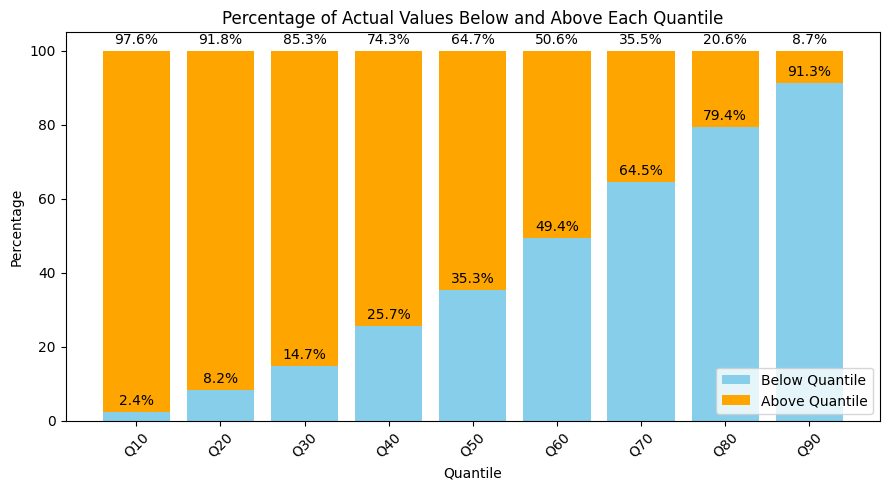

In [8]:
quantile_stats(quantile_predictions_df)

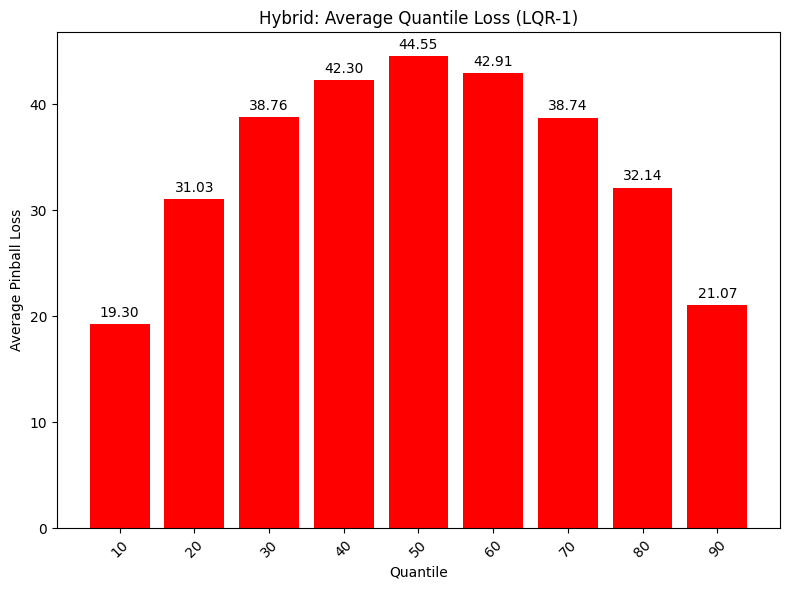

In [9]:
calculate_and_plot_average_quantile_loss(quantile_predictions_df, 'total_generation_MWh', "Hybrid: Average Quantile Loss (LQR-1)")